In [1]:
import torch

import image_encoder.loader as loader
import image_encoder.utility as utility
import image_encoder.transformers as transformers

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


In [2]:
loader_params = {
    "batch_size": 1,
    "pad_images": True,
    "percent_mask": 0.1,
    "shuffle": True
}

dataloader = loader.get_dataloader('dict_traindata.txt', loader_params)
ViT = transformers.VisionTransformer.load_model('image_encoder/trained_models/vit_20241110_75k.pth')
ViT = ViT.to(device)

C:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\image_encoder\transformers\vision_transformer.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chec

Vision Transformer instantiated with 75,232 parameters.
Model loaded from image_encoder/trained_models/vit_20241110_75k.pth on cpu


# Visualizing Our Attention

In [3]:
sample_u, sample_attn = None, None
with torch.no_grad():
    ViT.eval()
    for i, (ids, u, u_masks, v, v_masks) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        # Forward pass
        cls_logits, patch_logits, attn = ViT(u, save_attn=True, temperature=1)

        sample_attn = attn[0][0, 1].cpu()
        sample_u = u[0].cpu()
        break

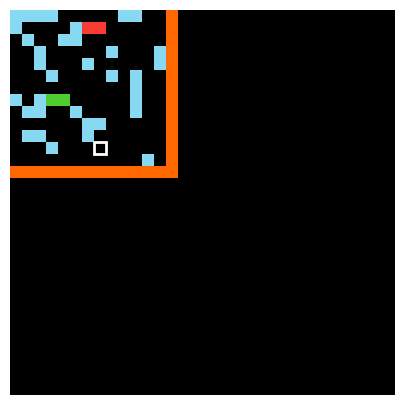

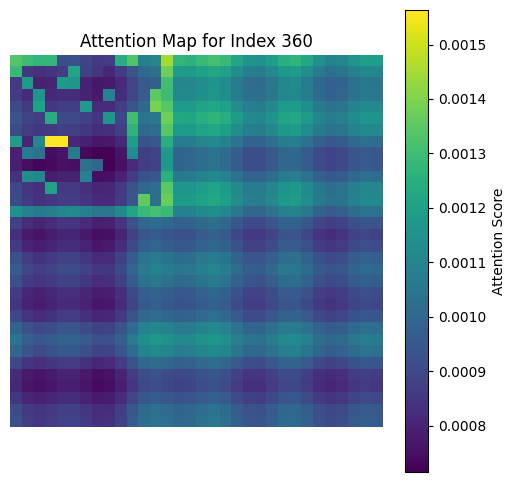

In [4]:
idx = utility.get_idx(x=7, y=11, CLS=False)
utility.plot_tensor_with_highlight(sample_u, idx)
utility.plot_attention_map(sample_attn, idx)

# Cosine Sim on CLS Token

In [5]:
# This will take some time -- it is generating CLS token embeddings for all images in the dataset
ids_list = []
images_tensor = []
cls_tensor = []

with torch.no_grad():
    ViT.eval()
    for i, (ids, u, u_masks, v, v_masks) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        cls_logits, _, _ = ViT(u, save_attn=False, temperature=1)

        ids_list.extend(ids)
        images_tensor.append(u.cpu())
        cls_tensor.append(cls_logits[:, 0].cpu())
        if i == 1000:
            break   # Can remove this line to run on the entire dataset
        
    images_tensor = torch.cat(images_tensor, dim=0)
    cls_tensor = torch.cat(cls_tensor, dim=0)

ID: <built-in function id>


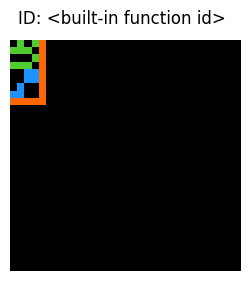


Closest 10 images:


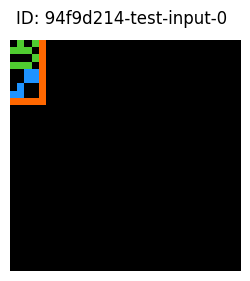

Similarity = 1.000



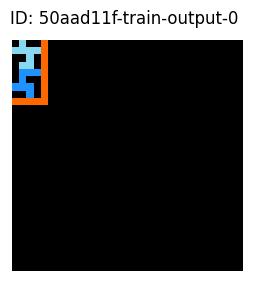

Similarity = 0.999



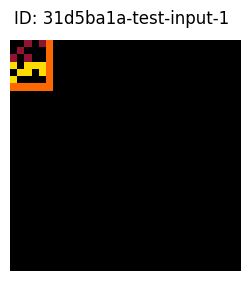

Similarity = 0.990



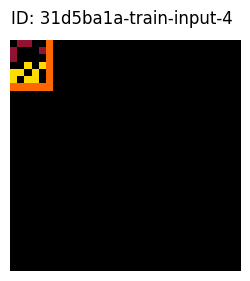

Similarity = 0.989



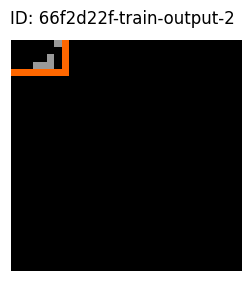

Similarity = 0.989



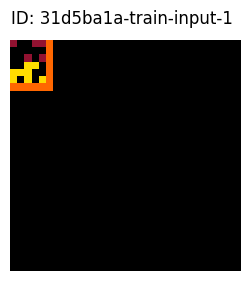

Similarity = 0.989



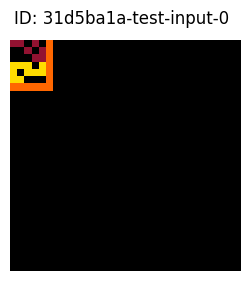

Similarity = 0.988



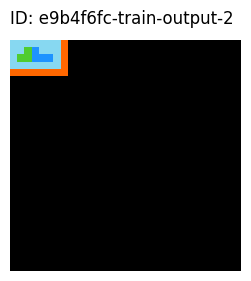

Similarity = 0.988



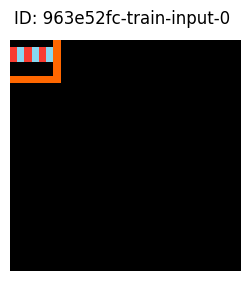

Similarity = 0.984



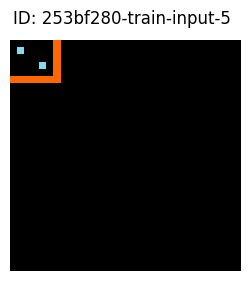

Similarity = 0.982

Furthest 10 images:


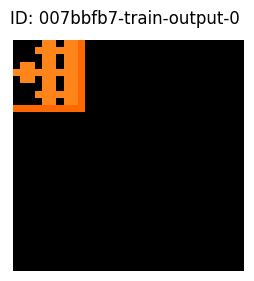

Similarity = -0.368



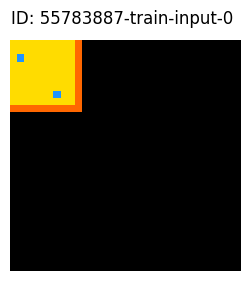

Similarity = -0.362



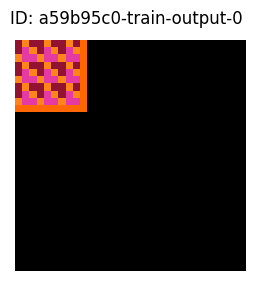

Similarity = -0.359



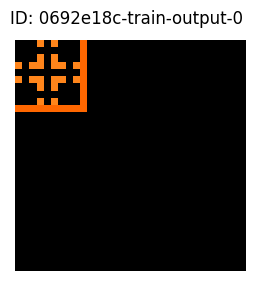

Similarity = -0.359



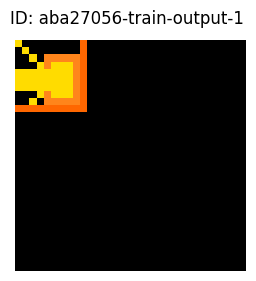

Similarity = -0.359



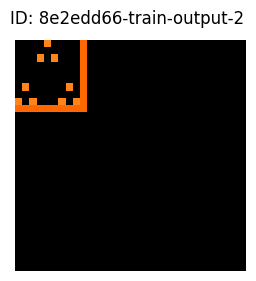

Similarity = -0.355



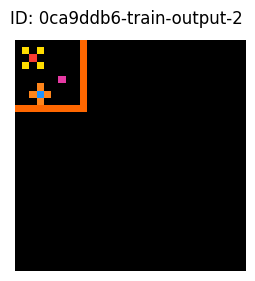

Similarity = -0.354



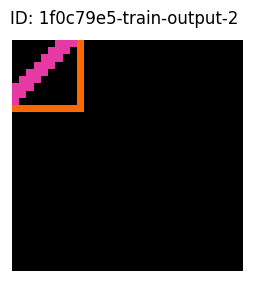

Similarity = -0.353



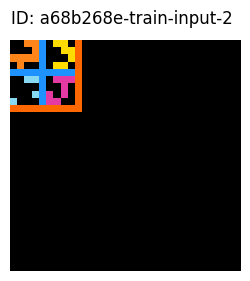

Similarity = -0.353



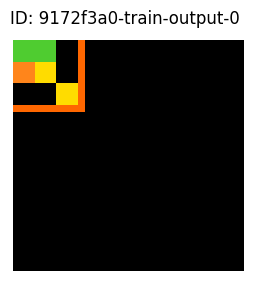

Similarity = -0.352



In [6]:
# Compute cosine similarity for given id
# id  = 'd4a91cb9-train-output-1'
# idx = ids_list.index(id)
idx = 30

print(f"ID: {id}")
utility.plot_tensors_with_colors(images_tensor[idx:idx+1], f"ID: {id}")
print(f"{'='*60}\n")

# Compute our closest and furthest embeddings
k = 10
closest_embeddings, closest_sims = utility.top_k_cosine_similarity(cls_tensor, idx, k, largest=True)
furthest_embeddings, furthest_sims = utility.top_k_cosine_similarity(cls_tensor, idx, k, largest=False)


print(f"Closest {k} images:")
for i, closest_idx in enumerate(closest_embeddings):
    closest_id = ids_list[closest_idx]
    utility.plot_tensors_with_colors(images_tensor[closest_idx:closest_idx+1], f"ID: {closest_id}")
    print(f"Similarity = {closest_sims[i]:.3f}\n")

print(f"Furthest {k} images:")
for i, furthest_idx in enumerate(furthest_embeddings):
    furthest_id = ids_list[furthest_idx]
    utility.plot_tensors_with_colors(images_tensor[furthest_idx:furthest_idx+1], f"ID: {furthest_id}")
    print(f"Similarity = {furthest_sims[i]:.3f}\n")